In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import ipdb
import os
import bda_utils

In [2]:
config_df = pd.read_csv('./runs/config_df_70_569.csv', index_col=0)
config_df.columns = ['run', 'detector', 'mu', 't_pre']
config_df

,run,detector,mu,t_pre
0,70,0,0.0,3
1,71,0,0.0,4
2,72,0,0.0,5
3,73,0,0.0,6
4,74,0,0.0,7
...,...,...,...,...
495,565,9,0.9,3
496,566,9,0.9,4
497,567,9,0.9,5
498,568,9,0.9,6


In [3]:
def cal_conditional_dist(Xs, ys, Xt, yt):
    dist = 0
    for c in range(101):
        ind_s = bda_utils.get_class(ys.flatten())==c
        ind_t = bda_utils.get_class(yt.flatten())==c
        
        Xs_c = Xs[np.where(ind_s==True)[1], :]
        Xt_c = Xt[np.where(ind_t==True)[1], :]
        
        if Xs_c.shape[0]==0 and Xt_c.shape[0]!=0:
            dist_c = np.abs( - Xt_c.mean()/Xt_c.flatten().shape[0])
#         elif Xs_c.shape[0]!=0 and Xt_c.shape[0]==0:
            
#             dist_c = np.abs(Xs_c.mean()/Xs_c.flatten().shape[0])
#         elif Xs_c.shape[0]!=0 and Xt_c.shape[0]!=0:
# #             ipdb.set_trace()
#             dist_c = np.abs(Xs_c.mean()/Xs_c.flatten().shape[0] - Xt_c.mean()/Xt_c.flatten().shape[0])
        else:
            dist_c = 0
        dist += dist_c**2
    return dist

# 对于每个detector

In [237]:
det = 8
data_det = config_df.loc[config_df['detector']==det]
seq_len=12
data_det

,run,detector,mu,t_pre
400,470,8,0.0,3
401,471,8,0.0,4
402,472,8,0.0,5
403,473,8,0.0,6
404,474,8,0.0,7
405,475,8,0.1,3
406,476,8,0.1,4
407,477,8,0.1,5
408,478,8,0.1,6
409,479,8,0.1,7


## 关于$\mu$的敏感度分析

In [238]:
def plot_pre(t_pre):
    data_det_pre = data_det.loc[data_det['t_pre']==t_pre]

    s_a = pd.DataFrame([], columns=['mu', 't_pre', 'run', 'cond dist', 'marg dist e-5', 'nrmse', 'mape', 'smape', 'mae'])

    for i in range(len(data_det_pre)):
        folder_name = 'run' + str(data_det_pre.iloc[i, 0])
        mu = data_det_pre.iloc[i, 2]

        g_t_bda = pd.read_csv('./runs/'+folder_name+'/bda_regression_g_t.csv', header=None).to_numpy()
        pred_bda = pd.read_csv('./runs/'+folder_name+'/bda_regression_pred_result.csv', header=None).to_numpy()
        Xs = pd.read_csv('./runs/'+folder_name+'/Xs.csv', header=None).to_numpy()
        Xt = pd.read_csv('./runs/'+folder_name+'/Xt.csv', header=None).to_numpy()
        Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, t_pre)  
        Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, t_pre)
        Ys_3d = Ys_3d[:, t_pre-1:, :]
        Yt_3d = Yt_3d[:, t_pre-1:, :]
        
        Xs_new = pd.read_csv('./runs/'+folder_name+'/Xs_new.csv', header=None).to_numpy()
        Xt_new = pd.read_csv('./runs/'+folder_name+'/Xt_new.csv', header=None).to_numpy()
        cond_dist = cal_conditional_dist(Xs_new, Ys_3d[:78, :, 0], Xt_new, Yt_3d[:78, :, 0])
        
        marg_dist = (Xs_new.flatten().mean()/Xs_new.flatten().shape[0] - \
                Xt_new.flatten().mean()/Xt_new.flatten().shape[0])**2
        
        nrmse = bda_utils.nrmse_loss_func(pred_bda, g_t_bda, 0)
        mape = bda_utils.mape_loss_func(pred_bda, g_t_bda, 0)
        smape = bda_utils.smape_loss_func(pred_bda, g_t_bda, 0)
        mae = bda_utils.mae_loss_func(pred_bda, g_t_bda, 0)

        s_a.loc[i, :] = np.array([mu, t_pre, data_det_pre.iloc[i, 0], cond_dist, marg_dist*100000, nrmse, mape, smape, mae])

#     s_a[['nrmse', 'mape', 'smape', 'mae']].plot()
    return s_a

In [239]:
plot_pre(7)

,mu,t_pre,run,cond dist,marg dist e-5,nrmse,mape,smape,mae
0,0.0,7.0,474.0,0.048442,0.044163,0.141464,0.409517,0.322995,0.107079
1,0.1,7.0,479.0,0.057855,0.051826,0.155764,0.625828,0.380531,0.126715
2,0.2,7.0,484.0,0.056458,0.047434,0.151704,0.542188,0.347708,0.12047
3,0.3,7.0,489.0,0.05506,0.05049,0.153584,0.613366,0.373941,0.12452
4,0.4,7.0,494.0,0.0687,0.048715,0.153176,0.573807,0.366442,0.122948
5,0.5,7.0,499.0,0.061366,0.05794,0.149591,0.579022,0.358663,0.119019
6,0.6,7.0,504.0,0.076098,0.044081,0.15332,0.570865,0.356824,0.123636
7,0.7,7.0,509.0,0.072562,0.052133,0.140115,0.448163,0.321912,0.107787
8,0.8,7.0,514.0,0.079394,0.051106,0.14909,0.597127,0.363446,0.119307
9,0.9,7.0,519.0,0.066853,0.052479,0.134541,0.414386,0.30538,0.101724


<AxesSubplot:>

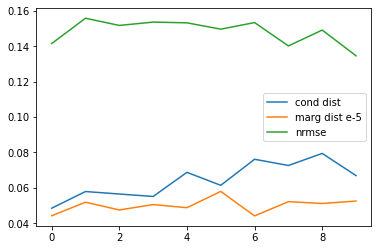

In [240]:
plot_pre(7)[['cond dist', 'marg dist e-5', 'nrmse']].plot()

In [241]:
min_loss_df = pd.DataFrame([], columns=['nrmse', 'mape', 'smape', 'mae'])

for t_pre in range(3, 8):
    s_a_pre = plot_pre(t_pre)
    loss_min = np.min(s_a_pre.to_numpy(), axis=0)[5:]
    min_loss_df.loc[t_pre-3, :] = loss_min

### base model

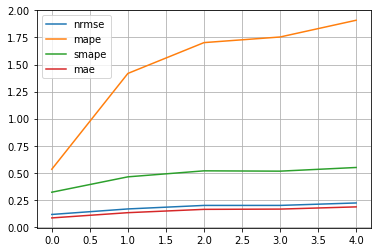

In [242]:
config_df_base = pd.read_csv('./runs_base/config_df_base.csv', index_col=0)
data_base_det = config_df_base.loc[config_df_base['detector']==det]
s_a_l_base = pd.DataFrame([], columns=['t_pre', 'nrmse', 'mape', 'smape', 'mae'])

for i in range(len(data_base_det)):
    folder_name = 'run' + str(data_base_det.iloc[i, 0])
    t_pre = data_base_det.iloc[i, 2]
    
    g_t_base = pd.read_csv('./runs_base/'+folder_name+'/base_regression_g_t.csv', header=None).to_numpy()
    pred_base = pd.read_csv('./runs_base/'+folder_name+'/base_regression_pred_result.csv', header=None).to_numpy()
    nrmse = bda_utils.nrmse_loss_func(pred_base, g_t_base, 0)
    mape = bda_utils.mape_loss_func(pred_base, g_t_base, 0)
    smape = bda_utils.smape_loss_func(pred_base, g_t_base, 0)
    mae = bda_utils.mae_loss_func(pred_base, g_t_base, 0)
    
    s_a_l_base.loc[i, :] = np.array([t_pre, nrmse, mape, smape, mae])
    
s_a_l_base[['nrmse', 'mape', 'smape', 'mae']].plot()
# plt.ylim(0, 0.5)
plt.grid()

## 关于往后predict几个label的敏感度分析

### bda model

In [243]:
def plot_mu(mu):
    data_det_mu = data_det.loc[abs(data_det['mu']-mu) < 1e-3]

    s_a = pd.DataFrame([], columns=['mu', 't_pre', 'nrmse', 'mape', 'smape', 'mae'])

    for i in range(len(data_det_mu)):
        folder_name = 'run' + str(data_det_mu.iloc[i, 0])
        t_pre = data_det_mu.iloc[i, 3]

        g_t_bda = pd.read_csv('./runs/'+folder_name+'/bda_regression_g_t.csv', header=None).to_numpy()
        pred_bda = pd.read_csv('./runs/'+folder_name+'/bda_regression_pred_result.csv', header=None).to_numpy()
        nrmse = bda_utils.nrmse_loss_func(pred_bda, g_t_bda, 0)
        mape = bda_utils.mape_loss_func(pred_bda, g_t_bda, 0)
        smape = bda_utils.smape_loss_func(pred_bda, g_t_bda, 0)
        mae = bda_utils.mae_loss_func(pred_bda, g_t_bda, 0)

        s_a.loc[i, :] = np.array([mu, t_pre, nrmse, mape, smape, mae])

#     s_a[['nrmse', 'mape', 'smape', 'mae']].plot()
    return s_a

# Analysis

(array([0.  , 0.25, 0.5 , 0.75, 1.  , 1.25, 1.5 , 1.75, 2.  ]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

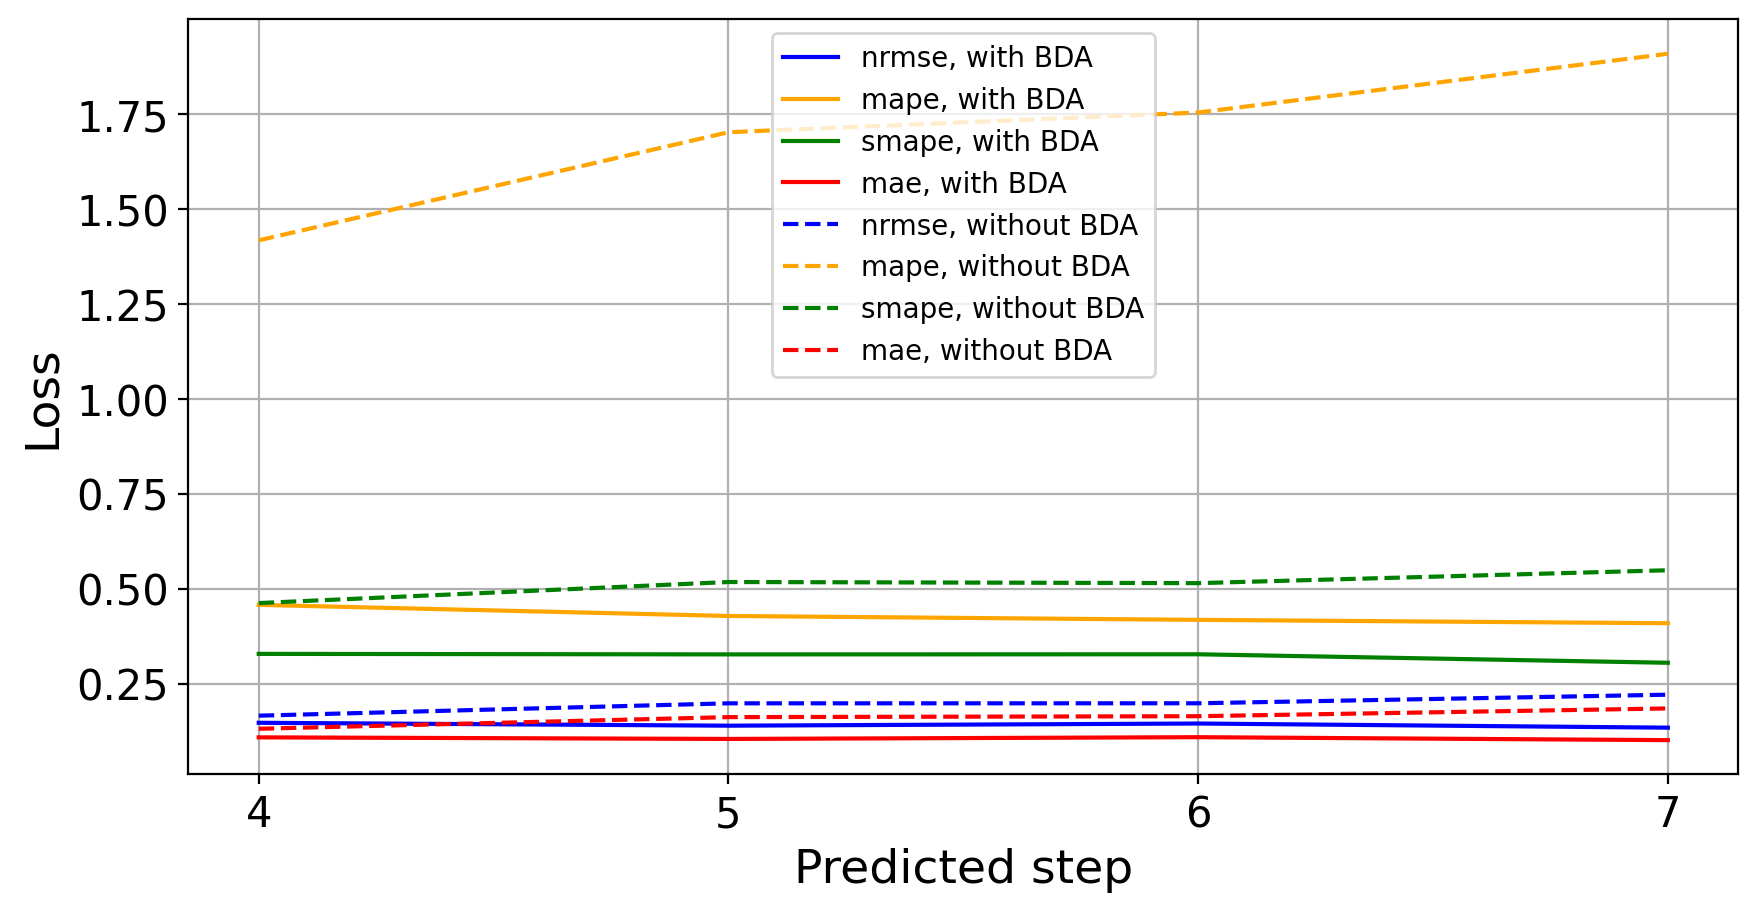

In [244]:
fig = plt.figure(figsize=[10,5], dpi=200)
ax = fig.add_subplot(111)
xtick = [4,5,6,7]
ax.plot(xtick, min_loss_df['nrmse'][1:], 'b', label='nrmse, with BDA')
ax.plot(xtick, min_loss_df['mape'][1:], 'orange', label='mape, with BDA')
ax.plot(xtick, min_loss_df['smape'][1:], 'g', label='smape, with BDA')
ax.plot(xtick, min_loss_df['mae'][1:], 'r', label='mae, with BDA')

ax.plot(xtick, s_a_l_base['nrmse'][1:], 'b--', label='nrmse, without BDA')
ax.plot(xtick, s_a_l_base['mape'][1:], '--', color='orange', label='mape, without BDA')
ax.plot(xtick, s_a_l_base['smape'][1:], 'g--', label='smape, without BDA')
ax.plot(xtick, s_a_l_base['mae'][1:], 'r--', label='mae, without BDA')
ax.legend(loc=9)
ax.grid()
ax.set_xlabel('Predicted step', fontsize=17)
ax.set_ylabel('Loss', fontsize=17)
ax.set_xticks(xtick)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
# plt.savefig('C:/Users/10169/iCloudDrive/Desktop/COTA/img/Loss vs t_pre %i.png'%det)

(0.0, 0.6)

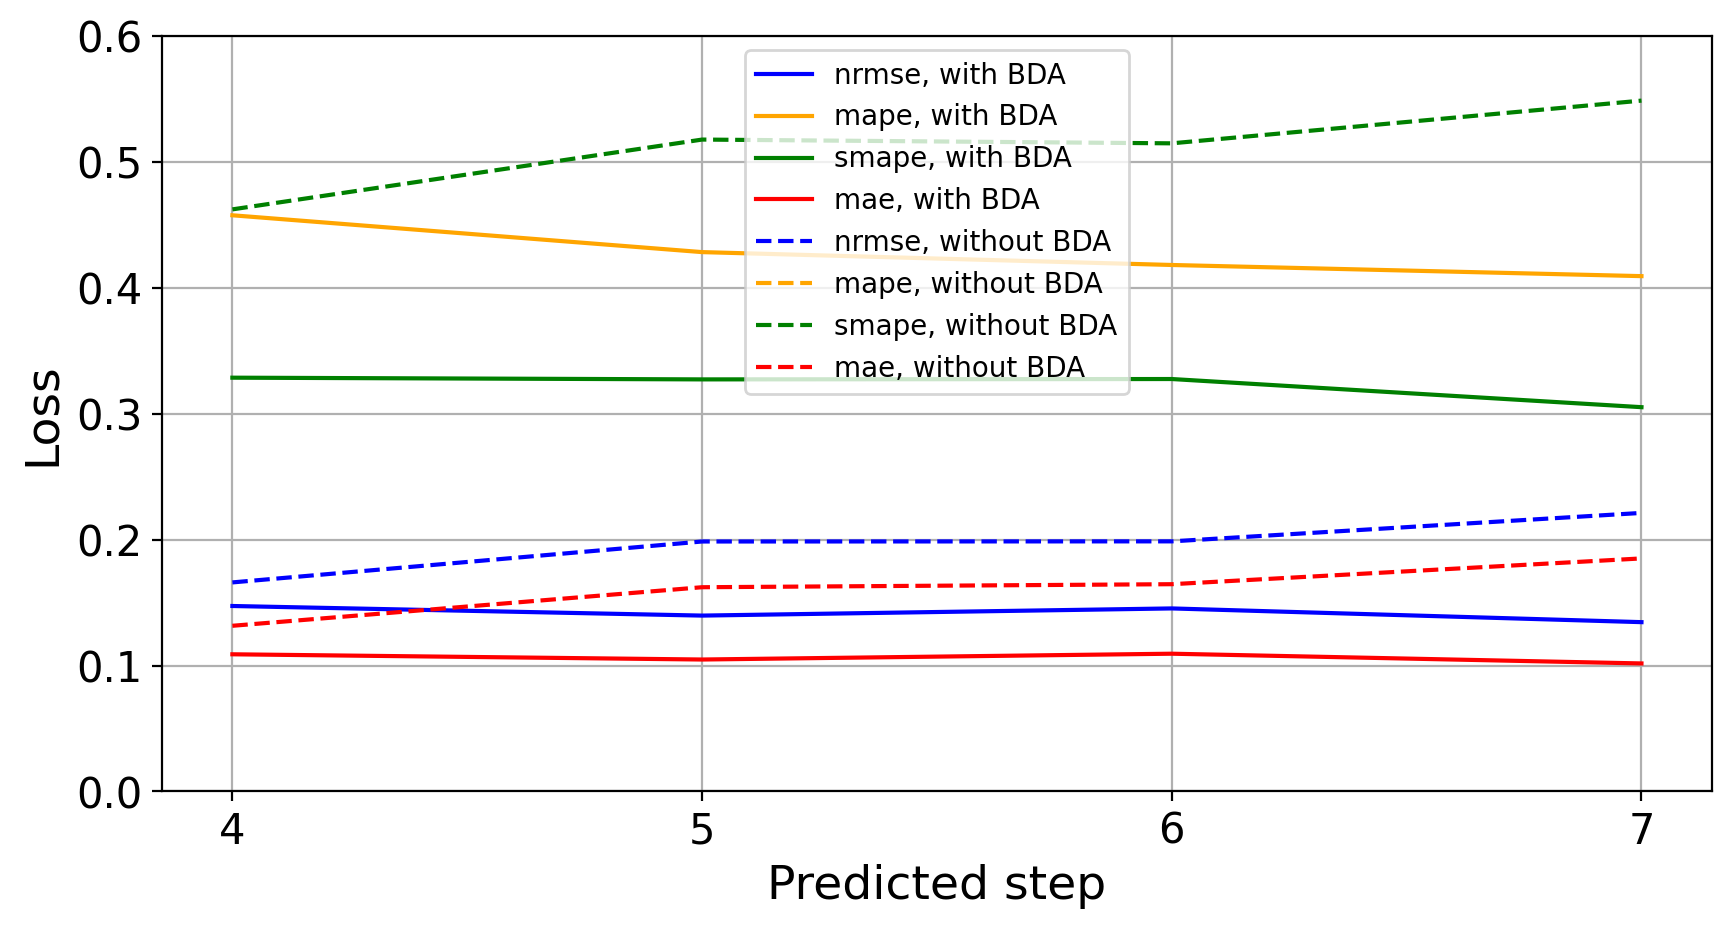

In [245]:
fig = plt.figure(figsize=[10,5], dpi=200)
ax = fig.add_subplot(111)
xtick = [4,5,6,7]
ax.plot(xtick, min_loss_df['nrmse'][1:], 'b', label='nrmse, with BDA')
ax.plot(xtick, min_loss_df['mape'][1:], 'orange', label='mape, with BDA')
ax.plot(xtick, min_loss_df['smape'][1:], 'g', label='smape, with BDA')
ax.plot(xtick, min_loss_df['mae'][1:], 'r', label='mae, with BDA')

ax.plot(xtick, s_a_l_base['nrmse'][1:], 'b--', label='nrmse, without BDA')
ax.plot(xtick, s_a_l_base['mape'][1:], '--', color='orange', label='mape, without BDA')
ax.plot(xtick, s_a_l_base['smape'][1:], 'g--', label='smape, without BDA')
ax.plot(xtick, s_a_l_base['mae'][1:], 'r--', label='mae, without BDA')
ax.legend(loc=9)
ax.grid()
ax.set_xlabel('Predicted step', fontsize=17)
ax.set_ylabel('Loss', fontsize=17)
ax.set_xticks(xtick)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
ax.set_ylim([0, 0.6])
# plt.savefig('C:/Users/10169/iCloudDrive/Desktop/COTA/img/Loss vs t_pre zoomed %i.png'%det)

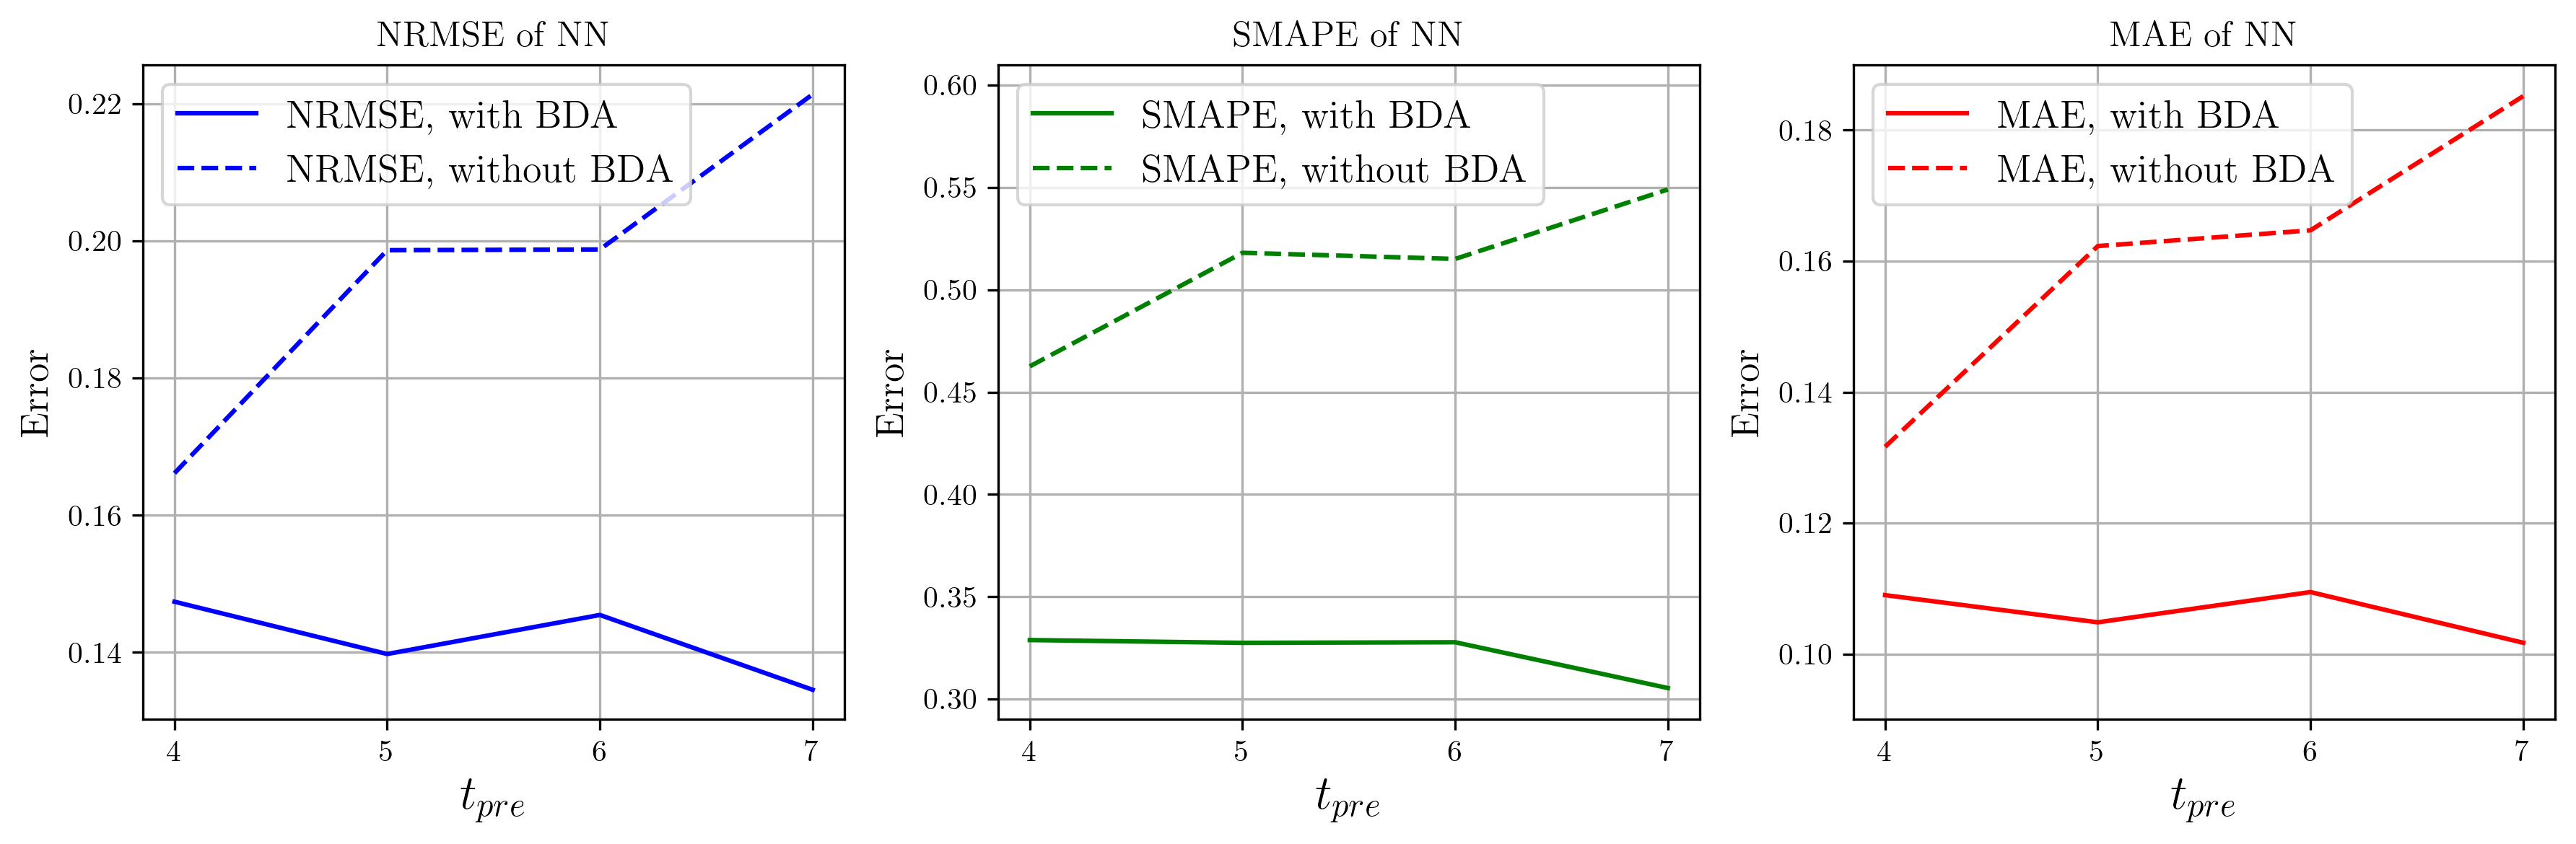

In [356]:
fig = plt.figure(figsize=[12,4], dpi=300)
xtick = [4,5,6,7]
plt.rc('text', usetex=True)
plt.rcParams["font.family"] = "Times New Roman"

ax1 = fig.add_subplot(131)
ax1.plot(xtick, min_loss_df['nrmse'][1:], 'b', label='NRMSE, with BDA')
ax1.plot(xtick, s_a_l_base['nrmse'][1:], 'b--', label='NRMSE, without BDA')
ax1.grid()
ax1.legend(loc=2, fontsize=13)
ax1.set_xlabel('$t_{pre}$', fontsize=16)
ax1.set_ylabel('Error', fontsize=13)
ax1.set_xticks(xtick)
ax1.set_title('NRMSE of NN')

# ax2 = fig.add_subplot(222)
# ax2.plot(xtick, min_loss_df['mape'][1:], 'orange', label='MAPE, with BDA')
# ax2.plot(xtick, s_a_l_base['mape'][1:], '--', color='orange', label='MAPE, without BDA')
# ax2.grid()
# ax2.legend(loc=2, fontsize=13)
# ax2.set_xlabel('$t_{pre}$', fontsize=16)
# ax2.set_ylabel('Error', fontsize=13)
# ax2.set_xticks(xtick)
# ax2.set_title('MAPE of NN')

ax3 = fig.add_subplot(132)
ax3.plot(xtick, min_loss_df['smape'][1:], 'g', label='SMAPE, with BDA')
ax3.plot(xtick, s_a_l_base['smape'][1:], 'g--', label='SMAPE, without BDA')
ax3.grid()
ax3.legend(loc=2, fontsize=13)
ax3.set_xlabel('$t_{pre}$', fontsize=16)
ax3.set_ylabel('Error', fontsize=13)
ax3.set_xticks(xtick)
ax3.set_title('SMAPE of NN')
ax3.set_ylim([0.29,0.61])

ax4 = fig.add_subplot(133)
ax4.plot(xtick, min_loss_df['mae'][1:], 'r', label='MAE, with BDA')
ax4.plot(xtick, s_a_l_base['mae'][1:], 'r--', label='MAE, without BDA')
ax4.grid()
ax4.legend(loc=2, fontsize=13)
ax4.set_xlabel('$t_{pre}$', fontsize=16)
ax4.set_ylabel('Error', fontsize=13)
ax4.set_xticks(xtick)
ax4.set_title('MAE of NN')
ax4.set_ylim([0.09,0.19])

# plt.xticks(fontsize=15)
# plt.yticks(fontsize=15)
ax.set_ylim([0, 0.6])
plt.tight_layout()
# plt.savefig('C:/Users/10169/iCloudDrive/Desktop/COTA/img/Error vs t_pre 4imgs %i.png'%det)

In [331]:
# run # , det=8, mu=0., t_pre=7
run = 509
label_seq_len = config_df.loc[config_df['run']==run, 't_pre'].values[0]
mu = config_df.loc[config_df['run']==run, 'mu'].values[0]
seq_len = 12

Xs = pd.read_csv('./runs/run'+str(run)+'/Xs.csv', header=None).to_numpy()
Xt = pd.read_csv('./runs/run'+str(run)+'/Xt.csv', header=None).to_numpy()
Xs_new = pd.read_csv('./runs/run'+str(run)+'/Xs_new.csv', header=None).to_numpy()
Xt_new = pd.read_csv('./runs/run'+str(run)+'/Xt_new.csv', header=None).to_numpy()

Xs_3d, Ys_3d = bda_utils.sliding_window(Xs, Xs, seq_len, label_seq_len)  
Xt_3d, Yt_3d = bda_utils.sliding_window(Xt, Xt, seq_len, label_seq_len)


Ys_3d = Ys_3d[:, label_seq_len-1:, :]
Yt_3d = Yt_3d[:, label_seq_len-1:, :]

In [332]:
from sklearn.manifold import TSNE
import sklearn
import warnings
warnings.filterwarnings('ignore')

In [333]:
Xt_new.shape

(462, 8)

9.592265971846268e-08
0.010911140851253824
5.213281479872177e-07
0.04936166871825976


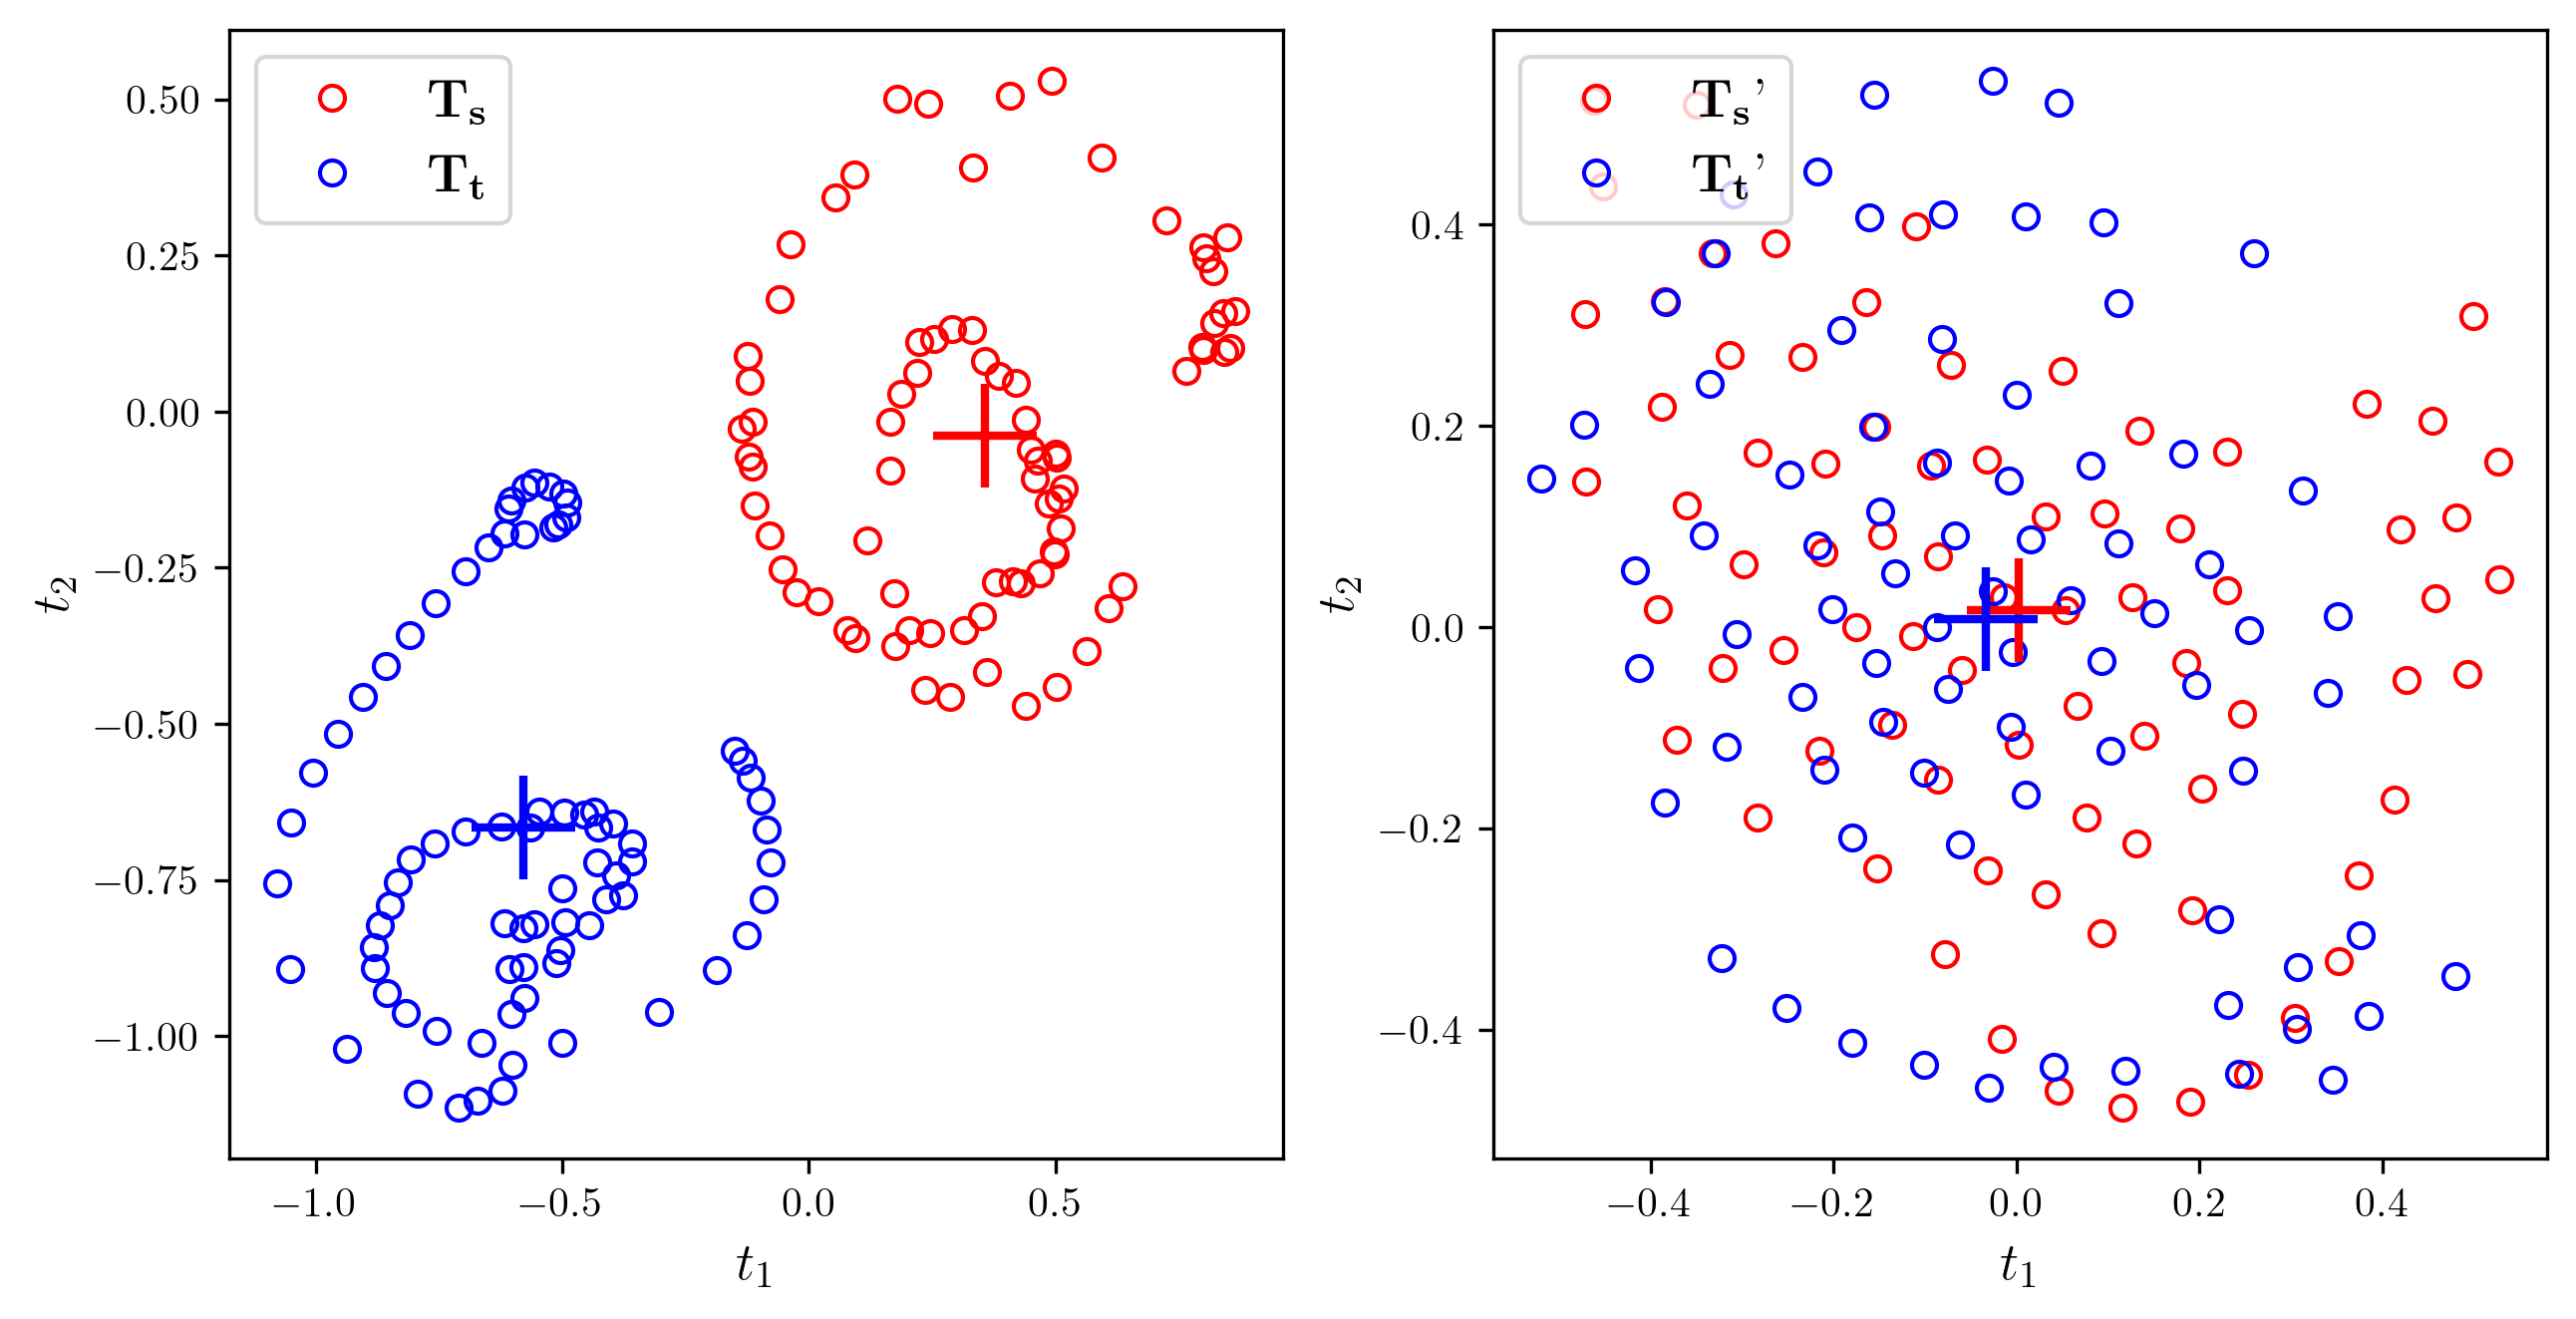

In [334]:
rs=32
dpi=300
bda_utils.setup_seed(rs)

pca_tsne = TSNE(n_components=2)  
Xs_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xs_3d[:, :, 0]))[0]
Xt_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xt_3d[:Xs_3d.shape[0], :, 0]))[0]
fig = plt.figure(figsize=[10, 5], dpi=dpi)
ax1 = fig.add_subplot(121)
ax1.plot(Xs_2D[:, 0], Xs_2D[:, 1], 'ro', markerfacecolor='none', label='$\mathbf{T}_\mathbf{s}$')
ax1.plot(Xt_2D[:, 0], Xt_2D[:, 1], 'bo', markerfacecolor='none', label='$\mathbf{T}_\mathbf{t}$')
ax1.plot(Xs_2D[:, 0].mean(), Xs_2D[:, 1].mean(), 'r+', markersize=25, markeredgewidth=2)
ax1.plot(Xt_2D[:, 0].mean(), Xt_2D[:, 1].mean(), 'b+', markersize=25, markeredgewidth=2)
ax1.set_xlabel('$t_1$', fontsize=13)
ax1.set_ylabel('$t_2$', fontsize=13)
ax1.legend(loc=2, fontsize=13)
marg_dist = (np.mean(Xs_3d.flatten())/Xs_3d.flatten().shape[0] - np.mean(Xt_3d.flatten())/Xt_3d.flatten().shape[0])**2
cond_dist = cal_conditional_dist(Xs_3d[:, :, 0], Ys_3d[:,:,0], Xt_3d[:, :, 0], Yt_3d[:,:,0])
print(marg_dist)
print(cond_dist)
# ax1.text(-1, 0.125, 'D(Ts, Tt)=%.3f*10^-4'%( 10000*((1-mu)*marg_dist + mu*cond_dist) ), fontsize=12)

Xs_new_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xs_new))[0]
Xt_new_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xt_new[:Xs_new.shape[0], :]))[0]
ax2 = fig.add_subplot(122)
ax2.plot(Xs_new_2D[:, 0], Xs_new_2D[:, 1], 'ro', markerfacecolor='none', label='$\mathbf{T}_\mathbf{s}$\'')
ax2.plot(Xt_new_2D[:, 0], Xt_new_2D[:, 1], 'bo', markerfacecolor='none', label='$\mathbf{T}_\mathbf{t}$\'')
ax2.plot(Xs_new_2D[:, 0].mean(), Xs_new_2D[:, 1].mean(), 'r+', markersize=25, markeredgewidth=2)
ax2.plot(Xt_new_2D[:, 0].mean(), Xt_new_2D[:, 1].mean(), 'b+', markersize=25, markeredgewidth=2)
ax2.set_xlabel('$t_1$', fontsize=13)
ax2.set_ylabel('$t_2$', fontsize=13)
ax2.legend(loc=2, fontsize=13)
marg_dist = (np.mean(Xs_new.flatten())/Xs_new.flatten().shape[0] - np.mean(Xt_new.flatten())/Xt_new.flatten().shape[0])**2
cond_dist = cal_conditional_dist(Xs_new, Ys_3d[:,:,0], Xt_new, Yt_3d[:,:,0])
print(marg_dist)
print(cond_dist)
# ax2.text(-0.1, 0.45, 'D(Ts\', Tt\')=%.3f*10^-4'%( 10000*((1-mu)*marg_dist + mu*cond_dist) ), fontsize=12)


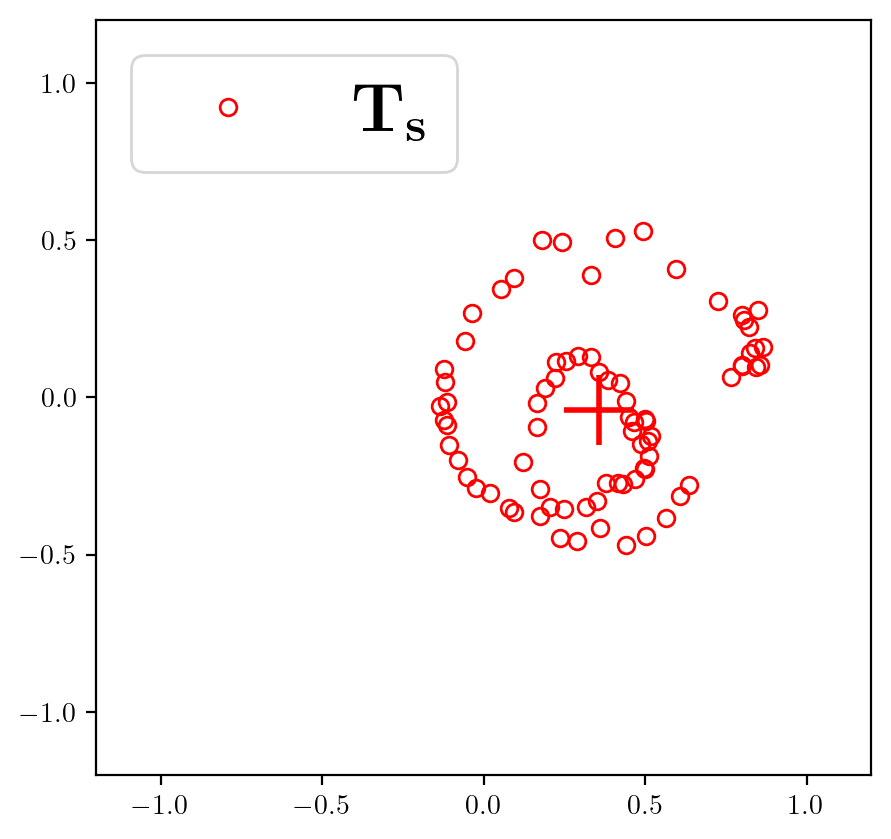

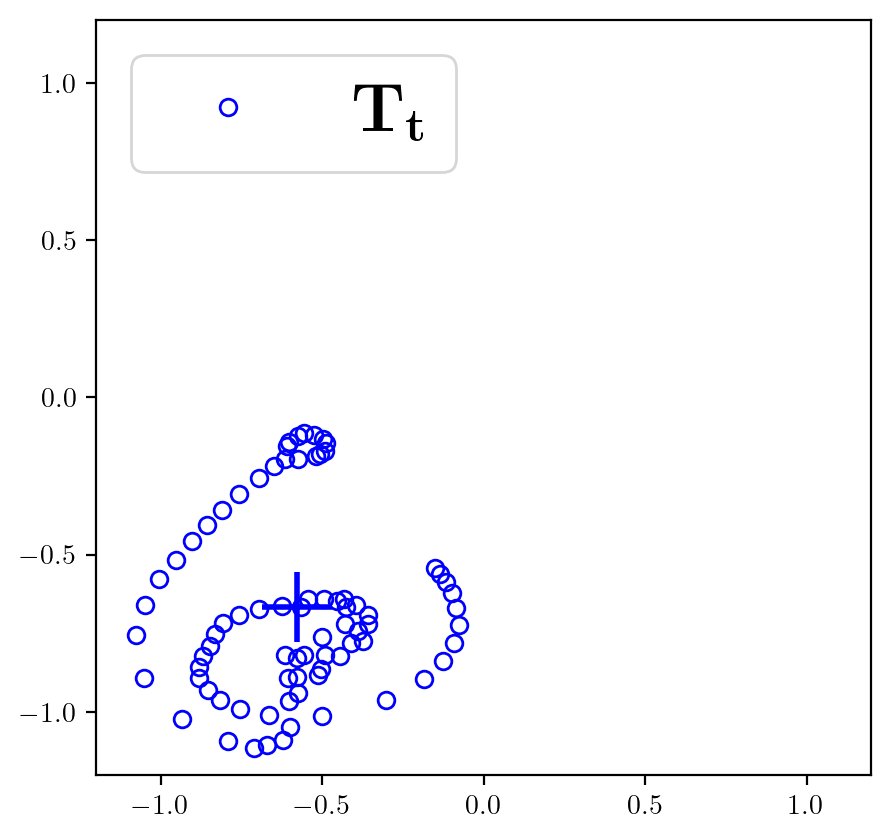

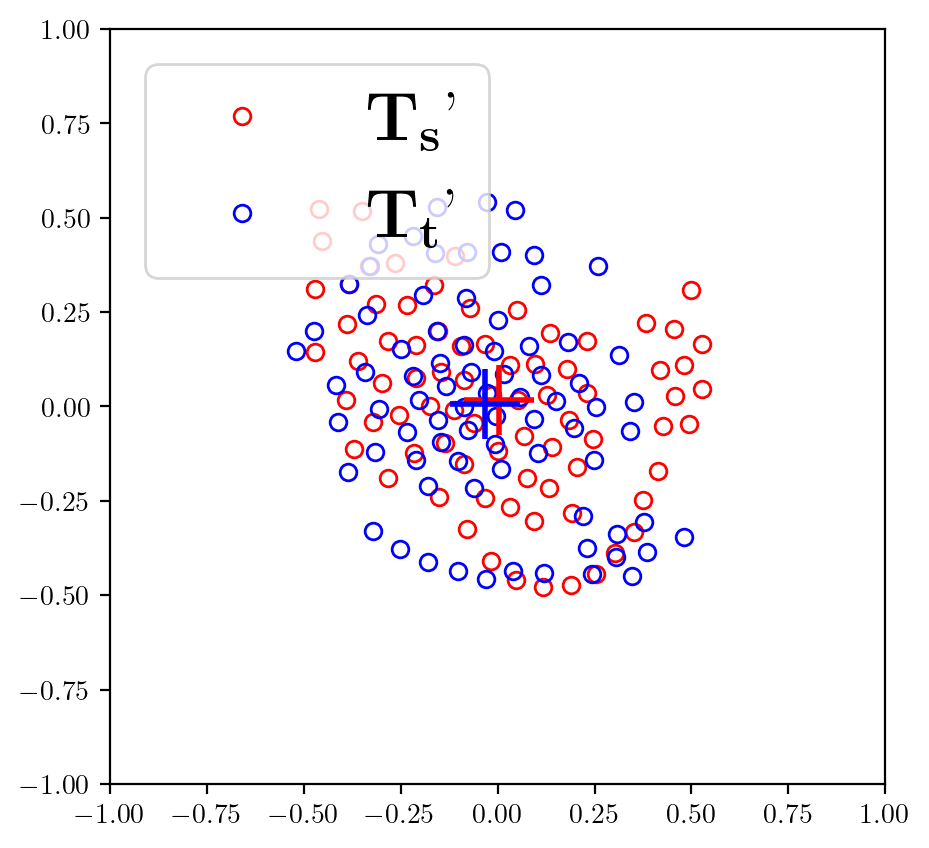

In [343]:
rs=32
dpi=200
bda_utils.setup_seed(rs)

pca_tsne = TSNE(n_components=2)  
Xs_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xs_3d[:, :, 0]))[0]
Xt_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xt_3d[:Xs_3d.shape[0], :, 0]))[0]
fig = plt.figure(figsize=[5, 5], dpi=dpi)
ax1 = fig.add_subplot(111)
ax1.plot(Xs_2D[:, 0], Xs_2D[:, 1], 'ro', markerfacecolor='none', label='$\mathbf{T}_\mathbf{s}$')
ax1.plot(Xs_2D[:, 0].mean(), Xs_2D[:, 1].mean(), 'r+', markersize=25, markeredgewidth=2)
ax1.legend(loc=2, fontsize=25)
ax1.set_xlim([-1.2, 1.2])
ax1.set_ylim([-1.2, 1.2])
marg_dist = (np.mean(Xs_3d.flatten())/Xs_3d.flatten().shape[0] - np.mean(Xt_3d.flatten())/Xt_3d.flatten().shape[0])**2
cond_dist = cal_conditional_dist(Xs_3d[:, :, 0], Ys_3d[:,:,0], Xt_3d[:, :, 0], Yt_3d[:,:,0])

fig = plt.figure(figsize=[5, 5], dpi=dpi)
ax1 = fig.add_subplot(111)
ax1.plot(Xt_2D[:, 0], Xt_2D[:, 1], 'bo', markerfacecolor='none', label='$\mathbf{T}_\mathbf{t}$')
ax1.plot(Xt_2D[:, 0].mean(), Xt_2D[:, 1].mean(), 'b+', markersize=25, markeredgewidth=2)
ax1.legend(loc=2, fontsize=25)
ax1.set_xlim([-1.2, 1.2])
ax1.set_ylim([-1.2, 1.2])
marg_dist = (np.mean(Xs_3d.flatten())/Xs_3d.flatten().shape[0] - np.mean(Xt_3d.flatten())/Xt_3d.flatten().shape[0])**2
cond_dist = cal_conditional_dist(Xs_3d[:, :, 0], Ys_3d[:,:,0], Xt_3d[:, :, 0], Yt_3d[:,:,0])


fig = plt.figure(figsize=[5, 5], dpi=dpi)
Xs_new_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xs_new))[0]
Xt_new_2D = bda_utils.normalize2D_tSNE(pca_tsne.fit_transform(Xt_new[:Xs_new.shape[0], :]))[0]
ax2 = fig.add_subplot(111)
ax2.plot(Xs_new_2D[:, 0], Xs_new_2D[:, 1], 'ro', markerfacecolor='none', label='$\mathbf{T}_\mathbf{s}$\'')
ax2.plot(Xt_new_2D[:, 0], Xt_new_2D[:, 1], 'bo', markerfacecolor='none', label='$\mathbf{T}_\mathbf{t}$\'')
ax2.plot(Xs_new_2D[:, 0].mean(), Xs_new_2D[:, 1].mean(), 'r+', markersize=25, markeredgewidth=2)
ax2.plot(Xt_new_2D[:, 0].mean(), Xt_new_2D[:, 1].mean(), 'b+', markersize=25, markeredgewidth=2)
ax2.legend(loc=2, fontsize=25)
ax2.set_xlim([-1, 1])
ax2.set_ylim([-1, 1])
marg_dist = (np.mean(Xs_new.flatten())/Xs_new.flatten().shape[0] - np.mean(Xt_new.flatten())/Xt_new.flatten().shape[0])**2
cond_dist = cal_conditional_dist(Xs_new, Ys_3d[:,:,0], Xt_new, Yt_3d[:,:,0])

# MMD

In [37]:
np.abs(np.mean(Xs_3d.flatten())/Xs_3d.flatten().shape[0] - np.mean(Xt_3d.flatten())/Xt_3d.flatten().shape[0])

0.0002817543504847127

In [38]:
np.abs(np.mean(Xs_new.flatten())/Xs_new.flatten().shape[0] - np.mean(Xt_new.flatten())/Xt_new.flatten().shape[0])

0.0006329899100028109

# A-distance

In [123]:
def proxy_a_distance(source_X, target_X):
    """
    Compute the Proxy-A-Distance of a source/target representation
    """
    nb_source = np.shape(source_X)[0]
    nb_target = np.shape(target_X)[0]

    train_X = np.vstack((source_X, target_X))
    train_Y = np.hstack((np.zeros(nb_source, dtype=int),
                         np.ones(nb_target, dtype=int)))

    clf = sklearn.svm.LinearSVC(random_state=0)
    clf.fit(train_X, train_Y)
    y_pred = clf.predict(train_X)
    error = sklearn.metrics.mean_absolute_error(train_Y, y_pred)
    dist = 2 * (1 - 2 * error)
    return dist

In [136]:
proxy_a_distance(Xs_new, Xt_new)

2.0

In [135]:
proxy_a_distance(Xs, Xt)

1.3333333333333335

# Illustration

In [282]:
config_df_pre = config_df[config_df['t_pre']==7]
config_df_pre_mu = config_df_pre[abs(config_df_pre['mu']-0.7)<1e-3]
config_df_pre_mu

,run,detector,mu,t_pre
39,109,0,0.7,7
89,159,1,0.7,7
139,209,2,0.7,7
189,259,3,0.7,7
239,309,4,0.7,7
289,359,5,0.7,7
339,409,6,0.7,7
389,459,7,0.7,7
439,509,8,0.7,7
489,559,9,0.7,7


In [283]:
t_pre = 7
config_df_base_pre = config_df_base[config_df_base['t_pre']==t_pre]
config_df_base_pre

,run,detector,t_pre
4,5,0,7
9,10,1,7
14,15,2,7
19,20,3,7
24,25,4,7
29,30,5,7
34,35,6,7
39,40,7,7
44,45,8,7
49,50,9,7


In [284]:
det = 8

In [285]:
run = config_df_pre_mu.loc[config_df_pre_mu['detector']==det, 'run'].values[0]
run_base = config_df_base_pre.loc[config_df_base_pre['detector']==det, 'run'].values[0]

In [286]:
g_t_base = pd.read_csv('./runs_base/run'+str(run_base)+'/base_regression_g_t.csv', header=None)
pred_base = pd.read_csv('./runs_base/run'+str(run_base)+'/base_regression_pred_result.csv', header=None)

g_t_bda = pd.read_csv('./runs/run'+str(run)+'/bda_regression_g_t.csv', header=None)
pred_bda = pd.read_csv('./runs/run'+str(run)+'/bda_regression_pred_result.csv', header=None)

_, Xt = bda_utils.load_data(if_weekday=1, if_interdet=1)
Xt = Xt[:, det:det+1]
Xt_3d, _ = bda_utils.sliding_window(Xt, Xt, seq_len, t_pre)
Xt_2d, Xt_min, Xt_max = bda_utils.normalize2D(Xt_3d[:, :, 0])

In [287]:
# min=15, max=903

Text(0, 0.5, 'Flow [veh/hr]')

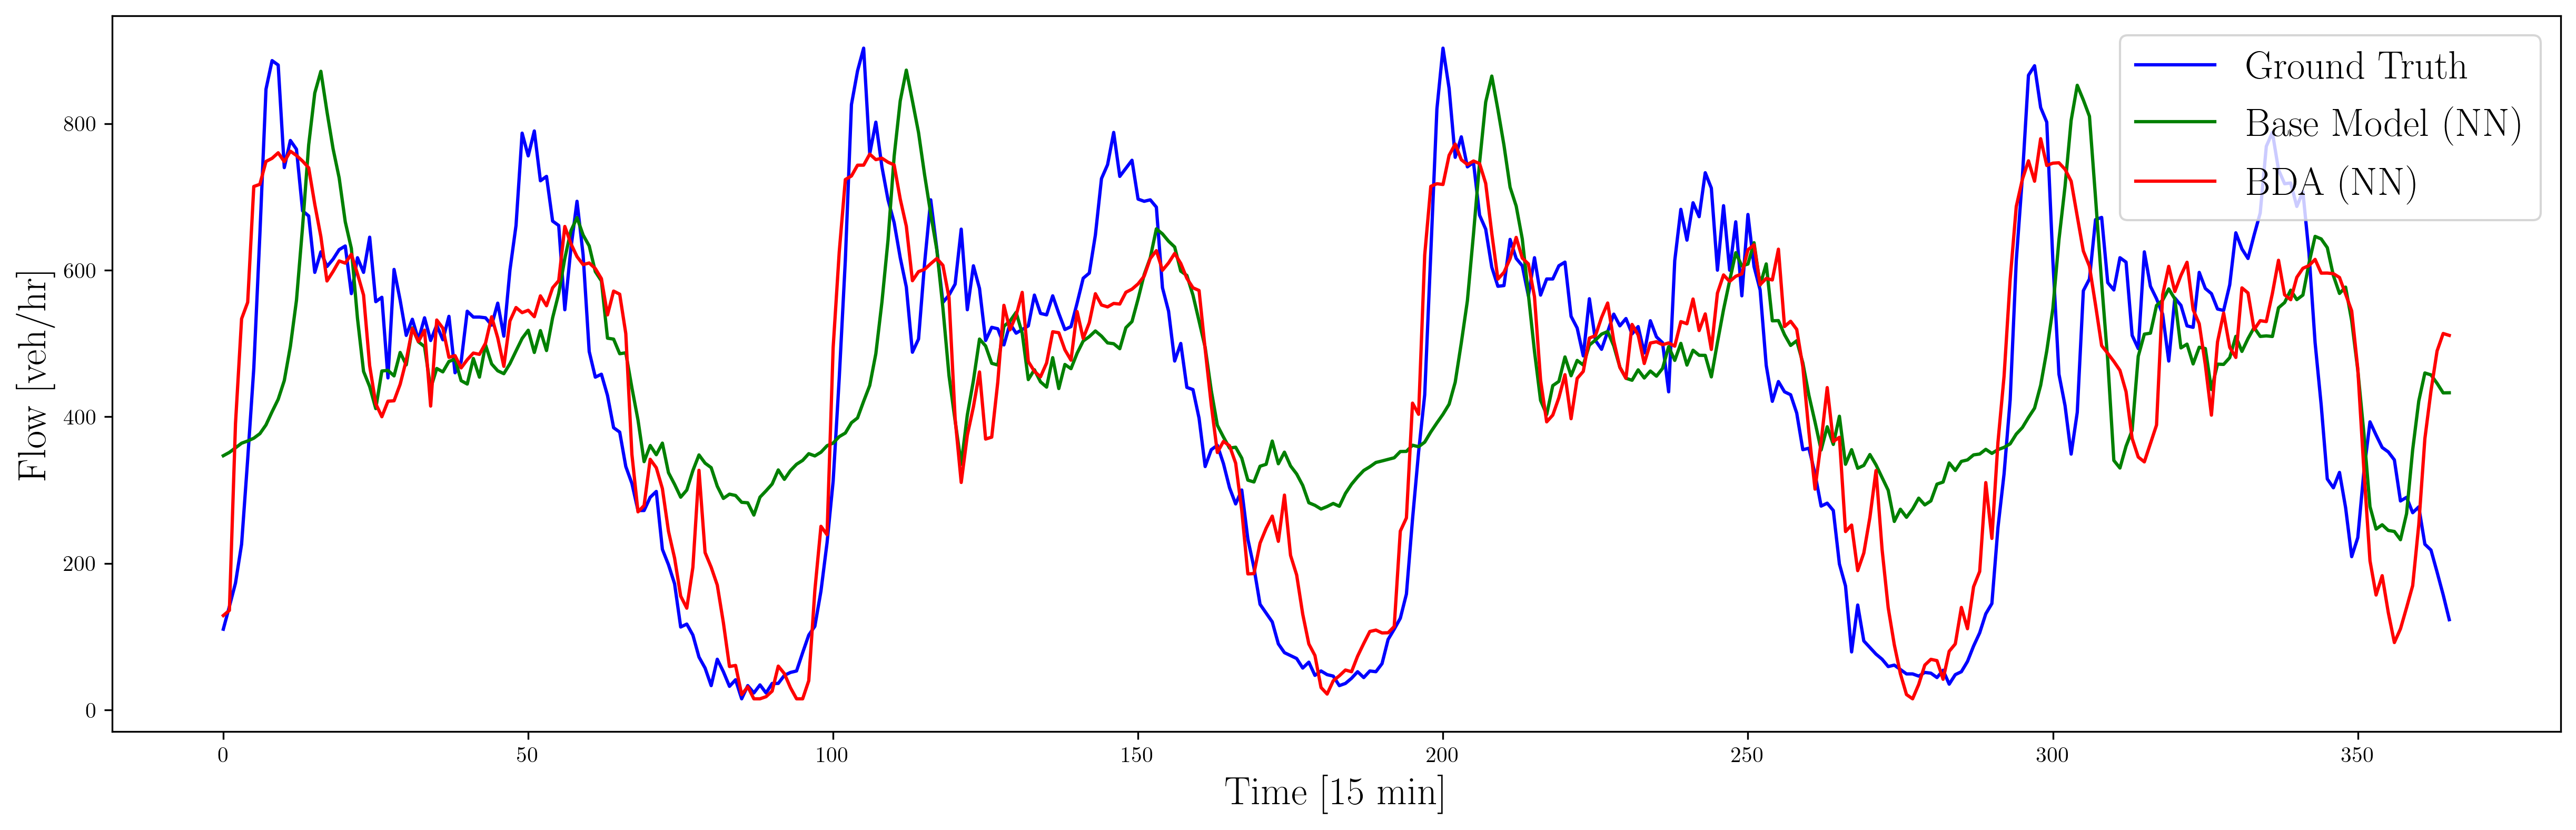

In [294]:
plt.figure(figsize=[20, 6], dpi=300)
diff = g_t_base.shape[0]-g_t_bda.shape[0]
plt.plot(range(g_t_bda.shape[0]), g_t_base[diff:]*(903-15)+15, 'b', label='Ground Truth')
plt.plot(range(g_t_bda.shape[0]), pred_base[diff:]*(903-15)+15, 'g', label='Base Model (NN)')
# plt.figure()
# plt.plot(range(371), g_t_bda)
plt.plot(range(g_t_bda.shape[0]), pred_bda*(903-15)+15, 'r', label='BDA (NN)')
plt.legend(loc=1, fontsize=18)
plt.xlabel('Time [15 min]', fontsize=18)
plt.ylabel('Flow [veh/hr]', fontsize=18)

# Raw data

In [307]:
if_interdet=1
if_weekday=1

file_set_2020 = [files for root, dirs, files in os.walk('./data/')][0][1::2]
# file_set_2020 = [files for root, dirs, files in os.walk('./data/')][0][2::2]

from_date = 55
to_date = 67

det_num = 23+13 if if_interdet==1 else 23
src_det_ind = 23 if if_interdet==1 else 13

if if_interdet==1:
    src_data = np.zeros([to_date - from_date, 96, 23])  # num_days, time_seg_per_day, num_dets
    tar_data = np.zeros([to_date - from_date, 96, 13])  # num_days, time_seg_per_day, num_dets
else:
    src_data = np.zeros([to_date - from_date, 96, 13])  # num_days, time_seg_per_day, num_dets
    tar_data = np.zeros([to_date - from_date, 96, 10])  # num_days, time_seg_per_day, num_dets

# choosing date, 
weekdays = np.array([6,7,8,9,10])
weekends = np.array([4,5,11])
day_type = weekdays if if_weekday else weekends
src_data = src_data[day_type, :, :]
tar_data = tar_data[day_type, :, :]

for i in range(det_num):  # 23 M1 csv
    # from_date 和 to_date
    if i<src_det_ind:
        src_data[:, :, i] += np.array(pd.read_csv('./data/'+file_set_2020[i]).iloc[from_date:to_date, 1:-1])[day_type, :]
    else:
        tar_data[:, :, i-src_det_ind] += np.array(pd.read_csv('./data/'+file_set_2020[i]).iloc[from_date:to_date, 1:-1])[day_type, :]

if if_interdet:
    Xs = src_data.reshape(-1, 23)[:, :13][:, np.array([0,1,2,3,5,6,8,9,10,11])]  # choosing detectors
    Xt = tar_data.reshape(-1, 13)[:, np.array([0,1,2,3,5,6,8,9,10,11])]
else:
    Xs = src_data.reshape(-1, 13)[:, np.array([0,1,2,3,5,6,8,9,10,11])]
    Xt = tar_data.reshape(-1, 10)

In [310]:
day = np.arange(from_date, to_date, 1)
day

array([55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66])

In [313]:
src_data.shape

(5, 96, 23)

In [322]:
# source detectors
selected = [0,1,2,3,5,6,8,9,10,11]
for i in range(len(file_set_2020[:23][:13])):
    if i in selected:
        print(file_set_2020[:23][:13][i])

# selected in paper: M1_2185B, M1_2220A, M1_2247B

M1_2114A_01012020_01012021.csv
M1_2116B_01012020_01012021.csv
M1_2147B_01012020_01012021.csv
M1_2149A_01012020_01012021.csv
M1_2181B_01012020_01012021.csv
M1_2185B_01012020_01012021.csv
M1_2220A_01012020_01012021.csv
M1_2220B_01012020_01012021.csv
M1_2247B_01012020_01012021.csv
M1_2253A_01012020_01012021.csv


In [325]:
# target detectors
selected = [0,1,2,3,5,6,8,9,10,11]
for i in range(len(file_set_2020[23:])):
    if i in selected:
        print(file_set_2020[23:][i])

# selected in paper: M4_2178B, M4_2188B, M4_2206B

M4_2156A_01012020_01012021.csv
M4_2156B_01012020_01012021.csv
M4_2162B_01012020_01012021.csv
M4_2168A_01012020_01012021.csv
M4_2178A_01012020_01012021.csv
M4_2178B_01012020_01012021.csv
M4_2188B_01012020_01012021.csv
M4_2206A_01012020_01012021.csv
M4_2206B_01012020_01012021.csv
M4_2210A_01012020_01012021.csv


In [315]:
Xs.shape

(480, 10)